In [1]:
import msprime
import tskit 
import top_down
import numpy as np 
import pyslim
import matplotlib.pyplot as plt

In [2]:
def Tree_estimates(ts): 
    # S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    S = list(ts.samples())
    breakpoints = list(ts.breakpoints())
    # print(breakpoints)
    n_breakpoints = len(breakpoints)
    mu_list = [] 
    sigma_list = []
    for i in range(n_breakpoints -1):  
        tree = ts.keep_intervals( np.array([[breakpoints[i],breakpoints[i+1]]]), simplify=False ) 
        tree = tree.rtrim()
        # print(tree.tables.edges)
        CM, indices, rootind = top_down.calc_covariance_matrix(tree)  
        loc = np.zeros((CM.shape[0],1))
        for i in S: 
            for j in indices[i]:
                ind = ts.tables.nodes[i].individual
                loc[j][0] = ts.tables.individuals[ind].location[0]
        CMinv = np.linalg.pinv(CM)
        mu, sigma = top_down.MLE(CMinv, loc, rootind =rootind ,n=len(S))
        mu_list += [ mu[0][0] ]
        sigma_list += [sigma[0][0]]
        
    return mu_list, sigma_list 

def Wilder_Wohns_mu(ts, weighted = True): 
    S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    loc = {i:ts.individuals()[i].location[0] for i in S} 
    time = {nd.id:nd.time for nd in ts.nodes() }
    for nd in ts.nodes(): 
        if nd.flags == 1 : 
            continue
        children = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd.id)]
        for child in children:
            if time[child] == time[nd.id]: 
                raise TypeError('Error',nd,child,time[child],time[nd.id])
        wghts = [1 for child in children]
        if weighted: 
            wghts =  [ 1.0/(time[nd.id] - time[child]) for child in children ]
            time[nd.id] -= 1.0/sum(wghts) 
        loc[nd.id] = np.average( [ loc[child] for child in children ] , weights = wghts)
    GMRCA = max( ts.nodes(), key = lambda nd : nd.id ) 
    return loc[GMRCA.id]


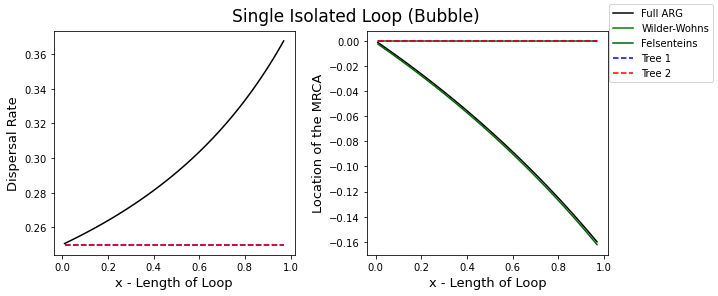

In [3]:
def ts_bubble( start=0.01, x = 0.25, t=1 ):     
    ts_bubble = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_bubble.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, start*t, start*t, (start+x)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_bubble.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_bubble.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 0.0]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 5, 4, 4, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_bubble.sort()
    return ts_bubble.tree_sequence()

x_range = np.arange(0.01,0.98,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_bubble(x=x)
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(1,2) 
ax[0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[0].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[1].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[1].set_ylabel('Location of the MRCA', fontsize = 13)
fig.suptitle('Single Isolated Loop (Bubble)', fontsize = 17)
fig.set_size_inches([10,4])
fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.898, wspace=0.3, hspace=0.405)

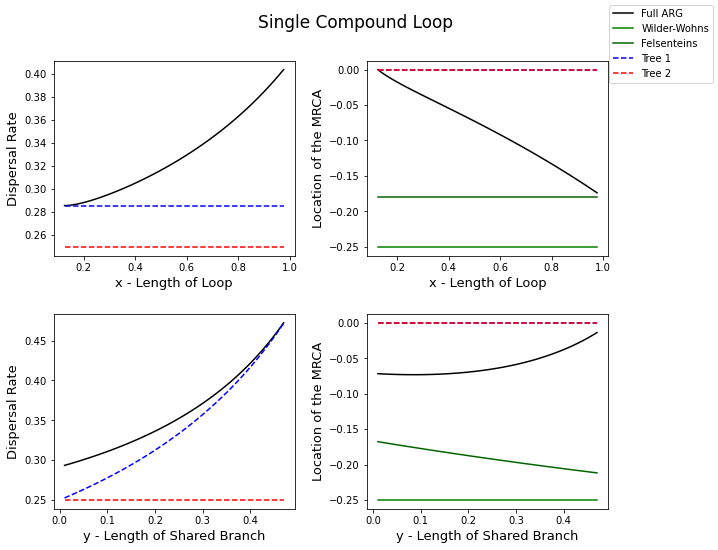

In [4]:
def ts_singlecompound(x=0.25, y=0.125, t=1 ):     
    ts_singlecompound = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 5e2]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 4, 4, 5, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound.sort()
    return ts_singlecompound.tree_sequence()

x_range = np.arange(0.126,0.98,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_singlecompound(x=x)
    # print(x)
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(2,2) 
ax[0][0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0][0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[0][1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0][0].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][1].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[0][1].set_ylabel('Location of the MRCA', fontsize = 13)
""" ---------------- """
y_range = np.arange(0.01,0.48,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound(x=0.5, y=y)
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[1][0].plot(y_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[1][0].plot(y_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[1][1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[1][0].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
ax[1][1].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
ax[1][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[1][1].set_ylabel('Location of the MRCA', fontsize = 13)
fig.suptitle('Single Compound Loop', fontsize = 17)
fig.set_size_inches([10,8])
fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.898, wspace=0.3, hspace=0.3)

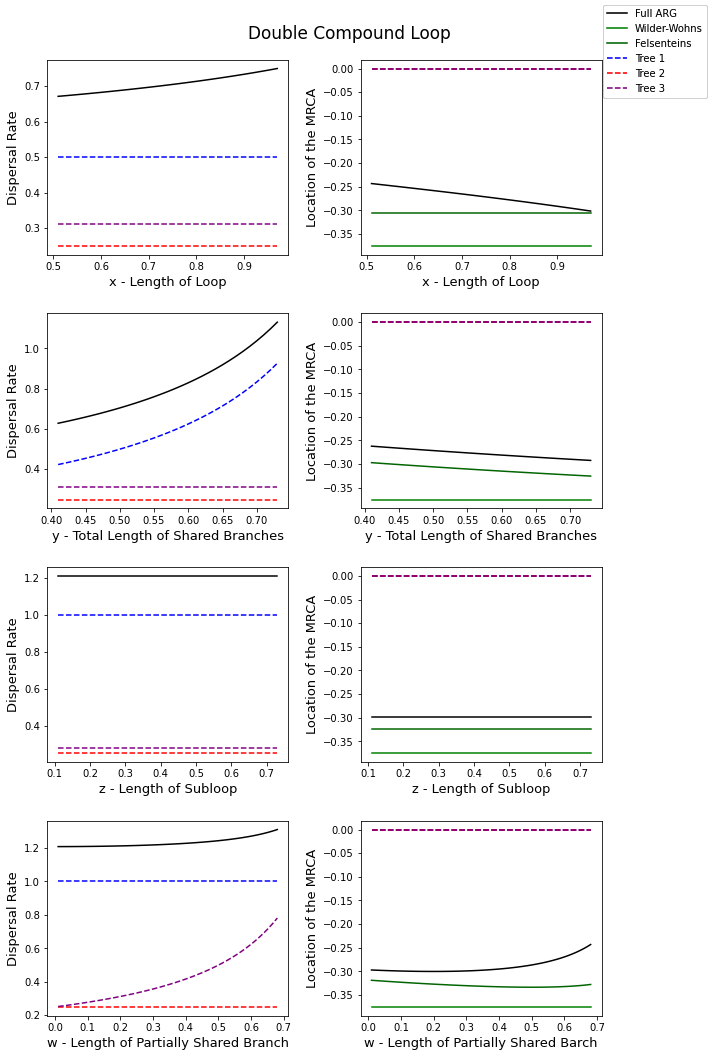

In [5]:
def ts_doublecompound(x=0.75, y=0.5, z = 0.4, w = 0.2, t=1): 
    ts_doublecompound = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_doublecompound.nodes
    node_table.set_columns(
        # flags = np.array([1, 1, 131072, 131072,0, 131072, 131072, 0 ,0], dtype=np.uint32),
        flags = np.array([1, 1, 0, 0,0, 0, 0, 0 ,0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, (1-z)*t, (1-z)*t, (1-w)*t, t ]),
        individual = np.array(list(range(2)) + [-1 for i in range(7)], dtype = np.int32)
    )
    
    individual_table = ts_doublecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_doublecompound.edges
    edge_table.set_columns(
        right=np.array([3e2, 1e3, 1e3, 3e2, 6e2, 1e3, 1e3, 6e2, 1e3, 6e2]),
        left=np.array([0.0, 3e2, 0.0, 0.0, 3e2, 6e2, 3e2, 3e2, 6e2, 3e2]),
        parent=np.array([2, 3, 4, 4, 5, 6, 7, 8, 7, 8], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 3, 4, 5, 6, 7], dtype=np.int32),  # References IDs in the node table
    )
    ts_doublecompound.sort()
    return ts_doublecompound.tree_sequence()

    
x_range = np.arange(0.51,0.98,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_doublecompound(x=x)
    # print(x)
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(4,2) 
ax[0][0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[0][1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[0][0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[0][1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0][0].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][1].set_xlabel('x - Length of Loop', fontsize = 13) 
ax[0][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[0][1].set_ylabel('Location of the MRCA', fontsize = 13)
""" ---------------- """
y_range = np.arange(0.41,0.74,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_doublecompound(y=y)
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[1][0].plot(y_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[1][1].plot(y_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[1][0].plot(y_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[1][1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[1][0].set_xlabel('y - Total Length of Shared Branches', fontsize = 13) 
ax[1][1].set_xlabel('y - Total Length of Shared Branches', fontsize = 13) 
ax[1][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[1][1].set_ylabel('Location of the MRCA', fontsize = 13)

""" ---------------- """
z_range = np.arange(0.11,0.74,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for z in z_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_doublecompound(x = 0.8, y = 0.75, z=z, w=0.1)
    # print(ts.draw_text())
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[2][0].plot(z_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[2][1].plot(z_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[2][1].plot(z_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[2][0].plot(z_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[2][1].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[2][0].set_xlabel('z - Length of Subloop', fontsize = 13) 
ax[2][1].set_xlabel('z - Length of Subloop', fontsize = 13) 
ax[2][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[2][1].set_ylabel('Location of the MRCA', fontsize = 13)

""" ---------------- """
w_range = np.arange(0.01,0.69,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for w in w_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_doublecompound(x = 0.8, y = 0.75, z = 0.7, w=w)
    mu, sigma = top_down.ARG_estimate(ts)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[3][0].plot(w_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
ax[3][1].plot(w_range, mu_fullARG, label = 'Full ARG', color = 'black') 
ax[3][1].plot(w_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
ax[3][1].plot(w_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red', 'purple']
for i in range(len(mu_trees)): 
    ax[3][0].plot(w_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
    ax[3][1].plot(w_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[3][0].set_xlabel('w - Length of Partially Shared Branch', fontsize = 13) 
ax[3][1].set_xlabel('w - Length of Partially Shared Barch', fontsize = 13) 
ax[3][0].set_ylabel('Dispersal Rate', fontsize = 13)
ax[3][1].set_ylabel('Location of the MRCA', fontsize = 13)
fig.suptitle('Double Compound Loop', fontsize = 17)
fig.set_size_inches([10,16])
fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.95, wspace=0.3, hspace=0.3)

In [6]:
def ts_singlecompound_3sam(x=0.25, y=0.125, z=0.25, t=1, loc = [-0.5,0,0.5] ):     
    ts_singlecompound_3sam = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound_3sam.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 1, 0, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, 0.0, z*t ,(1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(3)) + [-1,-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound_3sam.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0,0], dtype = np.uint32),
        location = np.array(loc),
        location_offset = np.array([0,1,2,3], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound_3sam.edges
    edge_table.set_columns(
        left=np.array([0.0, 0.0, 5e2, 0.0, 0.0, 5e2, 0, 5e2]),
        right=np.array([1e3, 1e3, 1e3, 5e2, 1e3, 1e3, 5e2, 1e3]),
        parent=np.array([3, 3, 4, 5, 6, 7, 6, 7], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 1, 3, 3, 2, 4, 5, 6], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound_3sam.sort()
    return ts_singlecompound_3sam.tree_sequence()

def singlecompound_3sam(midpoint, deviation, loc3):
    loc = [midpoint - deviation, midpoint + deviation, loc3]
    x_range = np.arange(0.126,0.74,0.01)
    mu_fullARG = [] 
    sigma_fullARG = [] 

    mu_trees = []
    sigma_trees = []

    mu_wohns = [] 
    mu_wohns_mod = [] 

    for x in x_range: 
        ts = ts_singlecompound_3sam(x=x,loc=loc)
        # print(x)
        mu, sigma = top_down.ARG_estimate(ts)
        mu_fullARG += [ mu[0][0] ]
        sigma_fullARG += [ sigma[0][0] ]

        mu_tree, sigma_tree = Tree_estimates(ts)
        mu_trees += [mu_tree]
        sigma_trees += [sigma_tree]

        mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
        mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

    fig, ax = plt.subplots(3,2) 
    ax[0][0].plot(x_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
    ax[0][1].plot(x_range, mu_fullARG, label = 'Full ARG', color = 'black') 
    ax[0][1].plot(x_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
    ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

    mu_trees = np.transpose(mu_trees)
    sigma_trees = np.transpose(sigma_trees)

    colors = ['blue', 'red']
    for i in range(len(mu_trees)): 
        ax[0][0].plot(x_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
        ax[0][1].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

    ax[0][0].set_xlabel('x - Length of Loop', fontsize = 13) 
    ax[0][1].set_xlabel('x - Length of Loop', fontsize = 13) 
    ax[0][0].set_ylabel('Dispersal Rate', fontsize = 13)
    ax[0][1].set_ylabel('Location of the MRCA', fontsize = 13)
    """ ---------------- """
    y_range = np.arange(0.01,0.48,0.01)
    mu_fullARG = [] 
    sigma_fullARG = [] 

    mu_trees = []
    sigma_trees = []

    mu_wohns = [] 
    mu_wohns_mod = [] 

    for y in y_range: 
        # print('----------------------',y,'------------------------')
        ts = ts_singlecompound_3sam(x=0.5, y=y,loc=loc)
        mu, sigma = top_down.ARG_estimate(ts)
        mu_fullARG += [ mu[0][0] ]
        sigma_fullARG += [ sigma[0][0] ]

        mu_tree, sigma_tree = Tree_estimates(ts)
        mu_trees += [mu_tree]
        sigma_trees += [sigma_tree]

        mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
        mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

    ax[1][0].plot(y_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
    ax[1][1].plot(y_range, mu_fullARG, label = 'Full ARG', color = 'black') 
    ax[1][1].plot(y_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
    ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

    mu_trees = np.transpose(mu_trees)
    sigma_trees = np.transpose(sigma_trees)

    colors = ['blue', 'red']
    for i in range(len(mu_trees)): 
        ax[1][0].plot(y_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
        ax[1][1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

    handles, labels = ax[0][1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    ax[1][0].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
    ax[1][1].set_xlabel('y - Length of Shared Branch', fontsize = 13) 
    ax[1][0].set_ylabel('Dispersal Rate', fontsize = 13)
    ax[1][1].set_ylabel('Location of the MRCA', fontsize = 13)
    """ ---------------- """
    z_range = np.arange(0.25,0.74,0.01)
    mu_fullARG = [] 
    sigma_fullARG = [] 

    mu_trees = []
    sigma_trees = []

    mu_wohns = [] 
    mu_wohns_mod = [] 

    for z in z_range: 
        # print('----------------------',y,'------------------------')
        ts = ts_singlecompound_3sam(z=z,loc=loc)
        mu, sigma = top_down.ARG_estimate(ts)
        mu_fullARG += [ mu[0][0] ]
        sigma_fullARG += [ sigma[0][0] ]

        mu_tree, sigma_tree = Tree_estimates(ts)
        mu_trees += [mu_tree]
        sigma_trees += [sigma_tree]

        mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
        mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

    ax[2][0].plot(z_range, sigma_fullARG, label = 'Full ARG', color = 'black') 
    ax[2][1].plot(z_range, mu_fullARG, label = 'Full ARG', color = 'black') 
    ax[2][1].plot(z_range, mu_wohns, label = 'Wilder-Wohns', color = 'green') 
    ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

    mu_trees = np.transpose(mu_trees)
    sigma_trees = np.transpose(sigma_trees)

    colors = ['blue', 'red']
    for i in range(len(mu_trees)): 
        ax[2][0].plot(z_range, sigma_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i] )
        ax[2][1].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

    handles, labels = ax[0][1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    ax[2][0].set_xlabel('z - Time to Coalescence', fontsize = 13) 
    ax[2][1].set_xlabel('z - Time to Coalescence', fontsize = 13) 
    ax[2][0].set_ylabel('Dispersal Rate', fontsize = 13)
    ax[2][1].set_ylabel('Location of the MRCA', fontsize = 13)

    fig.suptitle('Single Compound Loop with three samples', fontsize = 17)
    fig.set_size_inches([10,13])
    fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.95, wspace=0.3, hspace=0.3)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(singlecompound_3sam, midpoint = widgets.FloatSlider(value=-0.25, min=-50, max=50, step=0.5), deviation = widgets.FloatSlider(value=0.25, min=0, max=100, step=0.5), loc3 = widgets.FloatSlider(value=0.5, min=-50, max=50, step=0.5) )

interactive(children=(FloatSlider(value=-0.25, description='midpoint', max=50.0, min=-50.0, step=0.5), FloatSl…

<function __main__.singlecompound_3sam(midpoint, deviation, loc3)>

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_func(freq,amp):
    x = np.linspace(0, 2*np.pi)
    y = amp*np.sin(x * freq)
    plt.plot(x, y)

interact(plot_func, freq = widgets.FloatSlider(value=7.5, min=1, max=5.0, step=0.5), amp = widgets.FloatSlider(value=7.5, min=1, max=5.0, step=0.5))


interactive(children=(FloatSlider(value=5.0, description='freq', max=5.0, min=1.0, step=0.5), FloatSlider(valu…

<function __main__.plot_func(freq, amp)>